# ACC Survival Analysis: Nomogram Construction and Visualization

**Goal**: Create nomograms for risk prediction using the final multivariate Cox models

**Cohort**: Track A (primary analysis)

**Endpoints**: OS and CSS

**Method**: 
- Load final multivariate Cox models from notebook 03
- Build nomograms for OS and CSS prediction
- Visualize point assignment and risk scales
- Provide prediction examples

**Output**: 
- Nomogram visualizations (static and interactive)
- Point assignment tables
- Risk prediction calculator functions

## 1. Setup and Import Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from lifelines import CoxPHFitter
import warnings
import matplotlib.font_manager as fm

warnings.filterwarnings("ignore")

# Configure matplotlib to display Chinese characters
# Try to find a Chinese font on the system
chinese_fonts = [
    "PingFang SC",  # macOS default Chinese font
    "Heiti SC",  # macOS alternative
    "STHeiti",  # macOS alternative
    "SimHei",  # Windows
    "Microsoft YaHei",  # Windows
    "WenQuanYi Micro Hei",  # Linux
    "Arial Unicode MS",  # Fallback
]

# Find available font
available_font = None
system_fonts = [f.name for f in fm.fontManager.ttflist]

for font in chinese_fonts:
    if font in system_fonts:
        available_font = font
        break

if available_font:
    plt.rcParams["font.sans-serif"] = [available_font, "DejaVu Sans"]
    plt.rcParams["axes.unicode_minus"] = False  # Fix minus sign display
    print(f"Using font: {available_font}")
else:
    print("Warning: No Chinese font found, using default font")
    plt.rcParams["axes.unicode_minus"] = False

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

print("Libraries loaded successfully!")

Using font: STHeiti
Libraries loaded successfully!


## 2. Load Multivariate Model Results

In [25]:
# Load model results from notebook 03
data_dir = Path("../data/processed")

# Load OS model
with open(data_dir / "multivariate_os_model_trackA.json", "r") as f:
    os_model_results = json.load(f)

# Load CSS model
with open(data_dir / "multivariate_css_model_trackA.json", "r") as f:
    css_model_results = json.load(f)

print("OS Model:")
print(f"  Selected variables: {os_model_results['selected_variables']}")
print(f"  Training C-index: {os_model_results['performance']['training_c_index']:.4f}")
print(
    f"  Validation C-index: {os_model_results['performance']['validation_c_index']:.4f}"
)

print("\nCSS Model:")
print(f"  Selected variables: {css_model_results['selected_variables']}")
print(f"  Training C-index: {css_model_results['performance']['training_c_index']:.4f}")
print(
    f"  Validation C-index: {css_model_results['performance']['validation_c_index']:.4f}"
)

OS Model:
  Selected variables: ['TNMstage', 'age', 'chemotherapy', 'radiotherapy', 'marital_status', 'grade']
  Training C-index: 0.7706
  Validation C-index: 0.7206

CSS Model:
  Selected variables: ['TNMstage', 'grade', 'chemotherapy', 'age', 'tumor_number']
  Training C-index: 0.7963
  Validation C-index: 0.7694


## 3. Load Training Data for Nomogram Calibration

In [26]:
# Load training data to understand variable distributions
train = pd.read_pickle(data_dir / "trackA_train.pkl")
val = pd.read_pickle(data_dir / "trackA_val.pkl")

print(f"Training data: {train.shape}")
print(f"Validation data: {val.shape}")

# Display selected variables distributions
print("\n=" * 70)
print("VARIABLE DISTRIBUTIONS IN TRAINING DATA")
print("=" * 70)

for var in os_model_results["selected_variables"]:
    print(f"\n{var}:")
    print(train[var].value_counts().sort_index())

Training data: (926, 16)
Validation data: (457, 16)

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
VARIABLE DISTRIBUTIONS IN TRAINING DATA

TNMstage:
TNMstage
1            229
2            186
3            151
4              1
4A           177
4B            82
4C            95
4NOS           5
UNK Stage      0
Name: count, dtype: int64

age:
age
45-59    297
＜45      168
＞60      461
Name: count, dtype: int64

chemotherapy:
chemotherapy
No/Unknown    810
Yes           116
Name: count, dtype: int64

radiotherapy:
radiotherapy
No/Unknow    266
Yes          660
Name: count, dtype: int64

marital_status:
marital_status
丧偶       78
分居       12
同居未婚      3
已婚      535
未婚      176
未知       43
离异       79
Name: count, dtype: int64

grade:
grade
1分化好        53
2中分化       117
3分化差        61
4未分化间变性     34
不明         661
Name: count, dtype: int64


## 4. Create Point Assignment System

Nomograms use a point system where:
- Each variable level is assigned points based on its hazard ratio
- Points are standardized so the highest-risk category of the most important variable = 100 points
- Total points map to predicted survival probabilities

In [27]:
def translate_label_to_english(label):
    """
    Translate Chinese labels to English for better display compatibility.

    Args:
        label: Original label (may contain Chinese characters)

    Returns:
        Translated English label (ASCII only)
    """
    label_str = str(label)

    # Comprehensive medical term translations
    translations = {
        # Grade (differentiation/分化程度)
        "分化好": "Well diff.",
        "中分化": "Moderate diff.",
        "低分化": "Poor diff.",
        "未分化": "Undifferentiated",
        "高分化": "Well diff.",
        "Ⅰ级": "Grade I",
        "Ⅱ级": "Grade II",
        "Ⅲ级": "Grade III",
        "Ⅳ级": "Grade IV",
        "I级": "Grade I",
        "II级": "Grade II",
        "III级": "Grade III",
        "IV级": "Grade IV",
        # Yes/No
        "是": "Yes",
        "否": "No",
        "无": "No",
        "有": "Yes",
        "阴性": "Negative",
        "阳性": "Positive",
        # Sex/Gender
        "男": "Male",
        "女": "Female",
        "男性": "Male",
        "女性": "Female",
        # Age groups
        "岁": "y",
        "以下": "below",
        "以上": "above",
        "青年": "Young",
        "中年": "Middle-aged",
        "老年": "Elderly",
        # Marital status
        "已婚": "Married",
        "未婚": "Single",
        "离婚": "Divorced",
        "丧偶": "Widowed",
        # Race/Ethnicity
        "白人": "White",
        "黑人": "Black",
        "亚洲人": "Asian",
        "其他": "Other",
        # Tumor characteristics
        "肿瘤": "Tumor",
        "原发": "Primary",
        "转移": "Metastatic",
        "单发": "Solitary",
        "多发": "Multiple",
        "左侧": "Left",
        "右侧": "Right",
        "双侧": "Bilateral",
        # Size
        "厘米": "cm",
        "毫米": "mm",
        "小": "Small",
        "中": "Medium",
        "大": "Large",
        # Stage related
        "早期": "Early",
        "晚期": "Late",
        "局部": "Local",
        "区域": "Regional",
        "远处": "Distant",
        "期": "",
        # Treatment
        "手术": "Surgery",
        "化疗": "Chemo",
        "放疗": "Radio",
        "治疗": "Tx",
        "未治疗": "No Tx",
        "已治疗": "Treated",
        "接受": "Received",
        "未接受": "Not received",
        "完全切除": "Complete resection",
        "部分切除": "Partial resection",
        "姑息": "Palliative",
        "根治": "Curative",
        # Lymph nodes
        "淋巴结": "LN",
        "阳性淋巴结": "Positive LN",
        "阴性淋巴结": "Negative LN",
        "转移": "Metastasis",
        "无转移": "No metastasis",
        # General
        "未知": "Unknown",
        "缺失": "Missing",
        "不详": "Unknown",
        "未明确": "Unspecified",
        "正常": "Normal",
        "异常": "Abnormal",
        # Numbers in Chinese
        "一": "1",
        "二": "2",
        "三": "3",
        "四": "4",
        "五": "5",
        "六": "6",
        "七": "7",
        "八": "8",
        "九": "9",
        "十": "10",
        # Punctuation and connectors
        "和": "and",
        "或": "or",
        "与": "and",
        "至": "to",
    }

    # Apply translations
    translated = label_str
    for chinese, english in translations.items():
        translated = translated.replace(chinese, english)

    # FALLBACK: Remove any remaining non-ASCII characters
    ascii_only = ""
    for char in translated:
        if ord(char) < 128:
            ascii_only += char
        else:
            ascii_only += " "

    # Clean up extra spaces
    ascii_only = " ".join(ascii_only.split())

    if len(ascii_only.strip()) == 0:
        ascii_only = "Level"

    return ascii_only


def create_point_system(model_results, train_data):
    """
    Create a point assignment system for nomogram.

    Points are assigned based on coefficients:
    - Reference category (dropped first in dummy coding) = 0 points
    - Other categories get points proportional to their coefficients
    - Scaled so maximum = 100 points

    Args:
        model_results: Dict with model coefficients and variable info
        train_data: Training DataFrame to identify actual reference categories

    Returns:
        point_table: DataFrame with variable levels and assigned points
    """
    coefficients = model_results["coefficients"]

    # Find maximum absolute coefficient for scaling
    max_coef = max(abs(c) for c in coefficients.values())

    points_data = []

    for dummy_var, coef in coefficients.items():
        parts = dummy_var.split("_", 1)
        if len(parts) == 2:
            var_name, level = parts
        else:
            var_name = dummy_var
            level = "Unknown"

        # Translate variable and level names to ASCII-only English
        var_name_english = translate_label_to_english(var_name)
        level_english = translate_label_to_english(level)

        points = (coef / max_coef) * 100

        hr = model_results["hazard_ratios"][dummy_var]
        ci_lower = model_results["ci_lower"][dummy_var]
        ci_upper = model_results["ci_upper"][dummy_var]
        p_value = model_results["p_values"][dummy_var]

        points_data.append(
            {
                "Variable": var_name,
                "Variable_Display": var_name_english,
                "Level": level_english,
                "Level_Original": level,
                "Coefficient": coef,
                "HR": hr,
                "HR_CI_lower": ci_lower,
                "HR_CI_upper": ci_upper,
                "P_value": p_value,
                "Points": points,
            }
        )

    point_table = pd.DataFrame(points_data)

    variables = point_table["Variable"].unique()
    reference_rows = []

    for var in variables:
        if var in train_data.columns:
            if var == "TNMstage":
                levels = sorted(train_data[var].astype(str).unique())
            else:
                levels = sorted(train_data[var].unique())

            ref_level = levels[0]
            ref_level_english = translate_label_to_english(ref_level)
            var_name_english = translate_label_to_english(var)

            reference_rows.append(
                {
                    "Variable": var,
                    "Variable_Display": var_name_english,
                    "Level": ref_level_english,
                    "Level_Original": str(ref_level),
                    "Coefficient": 0.0,
                    "HR": 1.0,
                    "HR_CI_lower": 1.0,
                    "HR_CI_upper": 1.0,
                    "P_value": np.nan,
                    "Points": 0.0,
                }
            )

    point_table = pd.concat(
        [point_table, pd.DataFrame(reference_rows)], ignore_index=True
    )
    point_table = point_table.sort_values(["Variable_Display", "Points"])

    return point_table


print("Point system function with ASCII-only translation defined")

Point system function with ASCII-only translation defined


## 5. Build OS Nomogram Point System

In [28]:
print("=" * 70)
print("OS NOMOGRAM POINT SYSTEM")
print("=" * 70)

os_points = create_point_system(os_model_results, train)

# Display point assignments
print("\nPoint assignments for OS prediction:")
print(
    "\n",
    os_points[["Variable", "Level", "Points", "HR", "P_value"]].to_string(index=False),
)

# Calculate point ranges
print("\n--- Point Ranges by Variable ---")
for var in os_points["Variable"].unique():
    var_data = os_points[os_points["Variable"] == var]
    min_points = var_data["Points"].min()
    max_points = var_data["Points"].max()
    print(
        f"  {var}: {min_points:.1f} to {max_points:.1f} points (range: {max_points - min_points:.1f})"
    )

print(f"\nTotal possible points: 0 to {os_points['Points'].max():.1f}")

OS NOMOGRAM POINT SYSTEM

Point assignments for OS prediction:

     Variable             Level      Points       HR      P_value
    TNMstage                 4  -75.433869 0.156629 7.542275e-01
    TNMstage                 1    0.000000 1.000000          NaN
    TNMstage                 2   16.109684 1.485742 2.809975e-02
    TNMstage                 3   28.472917 2.013259 8.469914e-05
    TNMstage                4A   42.795978 2.862686 3.424230e-10
    TNMstage                4B   61.295445 4.510491 1.850813e-13
    TNMstage              4NOS   68.383989 5.368858 1.265250e-03
    TNMstage                4C   75.015496 6.319197 3.735807e-23
         age                45  -12.593156 0.733820 9.003161e-02
         age             45-59    0.000000 1.000000          NaN
         age                60   32.213920 2.207133 2.757140e-10
chemotherapy        No/Unknown    0.000000 1.000000          NaN
chemotherapy               Yes   31.145498 2.149933 4.225616e-07
       grade       1Well 

## 6. Build CSS Nomogram Point System

In [29]:
print("=" * 70)
print("CSS NOMOGRAM POINT SYSTEM")
print("=" * 70)

css_points = create_point_system(css_model_results, train)

# Display point assignments
print("\nPoint assignments for CSS prediction:")
print(
    "\n",
    css_points[["Variable", "Level", "Points", "HR", "P_value"]].to_string(index=False),
)

# Calculate point ranges
print("\n--- Point Ranges by Variable ---")
for var in css_points["Variable"].unique():
    var_data = css_points[css_points["Variable"] == var]
    min_points = var_data["Points"].min()
    max_points = var_data["Points"].max()
    print(
        f"  {var}: {min_points:.1f} to {max_points:.1f} points (range: {max_points - min_points:.1f})"
    )

print(f"\nTotal possible points: 0 to {css_points['Points'].max():.1f}")

CSS NOMOGRAM POINT SYSTEM

Point assignments for CSS prediction:

     Variable             Level     Points        HR      P_value
    TNMstage                 4 -59.389489  0.237862 8.227005e-01
    TNMstage                 1   0.000000  1.000000          NaN
    TNMstage                 2  26.298237  1.888727 9.531418e-03
    TNMstage                 3  33.097717  2.226247 1.127407e-03
    TNMstage                4A  58.023792  4.067549 1.857976e-10
    TNMstage                4B  75.879299  6.263848 3.097606e-13
    TNMstage                4C  96.926333 10.419938 7.192432e-23
    TNMstage              4NOS 100.000000 11.223881 9.353209e-05
         age                45  -7.236190  0.839479 3.682272e-01
         age             45-59   0.000000  1.000000          NaN
         age                60  19.802215  1.614179 1.048557e-03
chemotherapy        No/Unknown   0.000000  1.000000          NaN
chemotherapy               Yes  30.204267  2.075812 1.996114e-05
       grade       1Wel

## 7. Visualize Nomogram Structure

Create a simplified visual representation of the nomogram showing:
- Point scale for each variable
- Total points scale
- Survival probability scale

In [30]:
def format_level_label(level, max_len=12):
    """Shorten and wrap labels for cleaner display."""
    level = str(level)
    if len(level) <= max_len:
        return level
    return level[:max_len] + "\n" + level[max_len : max_len * 2]


def plot_nomogram_horizontal(point_table, title, figsize=(18, 9)):
    """
    Create a clean horizontal nomogram visualization.

    Args:
        point_table: DataFrame with variable points
        title: Plot title
        figsize: Figure size
    """
    fig, ax = plt.subplots(figsize=figsize)

    variables = point_table["Variable_Display"].unique()
    n_vars = len(variables)

    y_positions = np.arange(n_vars, 0, -1) * 1.5

    colors = sns.color_palette("Set2", n_colors=n_vars)

    for i, var_display in enumerate(variables):
        var_data = point_table[point_table["Variable_Display"] == var_display].copy()
        var_data = var_data.sort_values("Points")

        y = y_positions[i]
        color = colors[i]

        ax.text(
            -12, y, var_display, ha="right", va="center", fontweight="bold", fontsize=12
        )
        ax.hlines(y, 0, 100, color=color, linewidth=2, alpha=0.8)

        for j, row in enumerate(var_data.itertuples(index=False)):
            points = row.Points
            level = format_level_label(row.Level, max_len=10)

            ax.vlines(points, y - 0.22, y + 0.22, color=color, linewidth=2)

            # Alternate label position to avoid overlap
            label_y = y - 0.5 if j % 2 == 0 else y - 0.9
            ax.text(
                points,
                label_y,
                level,
                ha="center",
                va="top",
                fontsize=9,
                rotation=0,
            )

    y_total = 0
    ax.text(
        -12,
        y_total,
        "Total Points",
        ha="right",
        va="center",
        fontweight="bold",
        fontsize=12,
        color="#1f77b4",
    )
    ax.hlines(y_total, 0, 100, color="#1f77b4", linewidth=2.5)

    for p in range(0, 101, 10):
        ax.vlines(p, y_total - 0.25, y_total + 0.25, color="#1f77b4", linewidth=2)
        ax.text(
            p,
            y_total + 0.45,
            str(p),
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
            color="#1f77b4",
        )

    ax.set_xlim(-15, 105)
    ax.set_ylim(-1.2, max(y_positions) + 0.8)
    ax.set_title(title, fontsize=16, fontweight="bold", pad=20)
    ax.axis("off")

    plt.tight_layout()
    return fig


print("Nomogram plotting function defined")

Nomogram plotting function defined


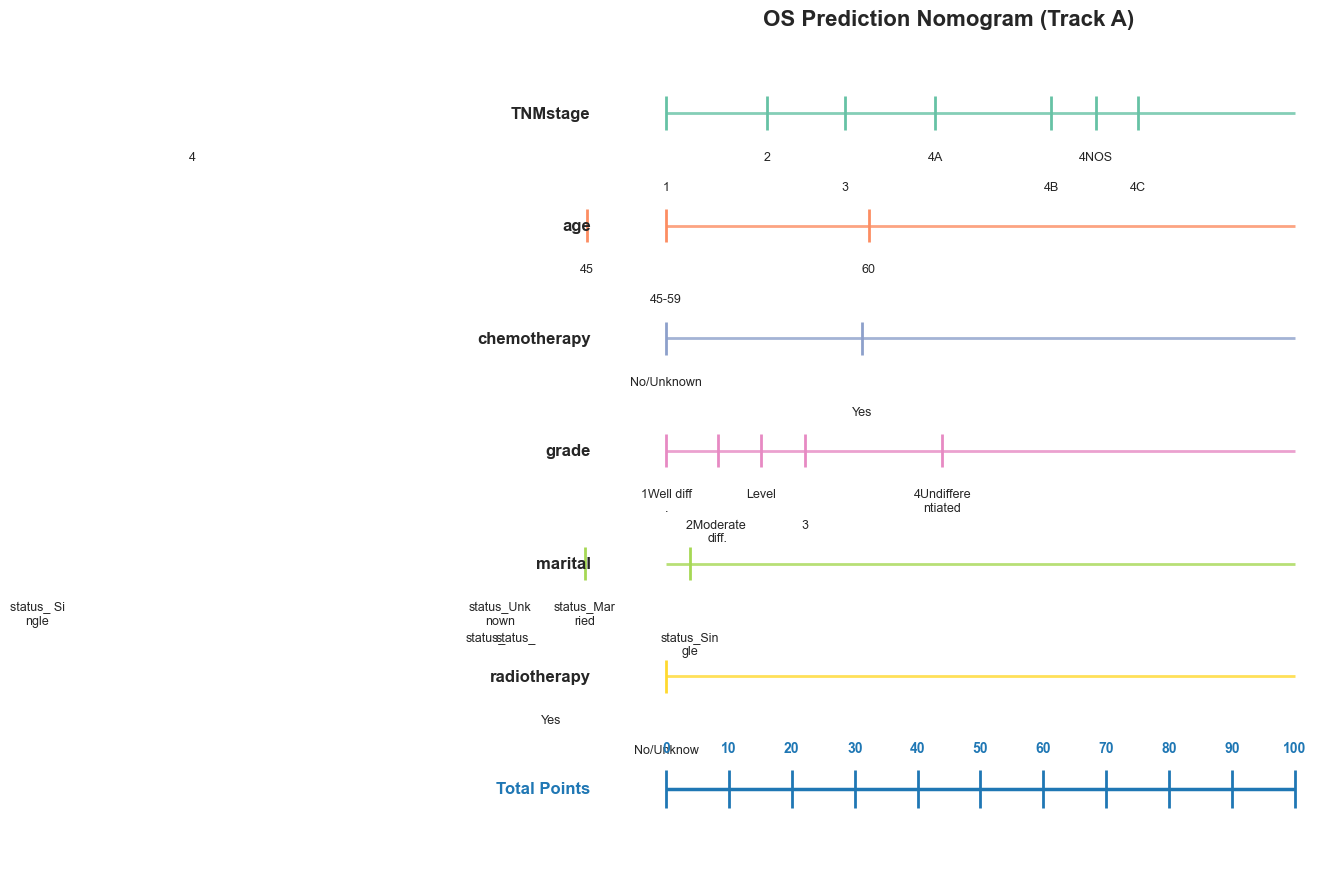


OS nomogram saved: nomogram_os_trackA.png


In [31]:
# Plot OS nomogram
fig_os = plot_nomogram_horizontal(os_points, "OS Prediction Nomogram (Track A)")
plt.show()

# Save figure
output_dir = Path("../data/processed")
fig_os.savefig(output_dir / "nomogram_os_trackA.png", dpi=300, bbox_inches="tight")
print("\nOS nomogram saved: nomogram_os_trackA.png")

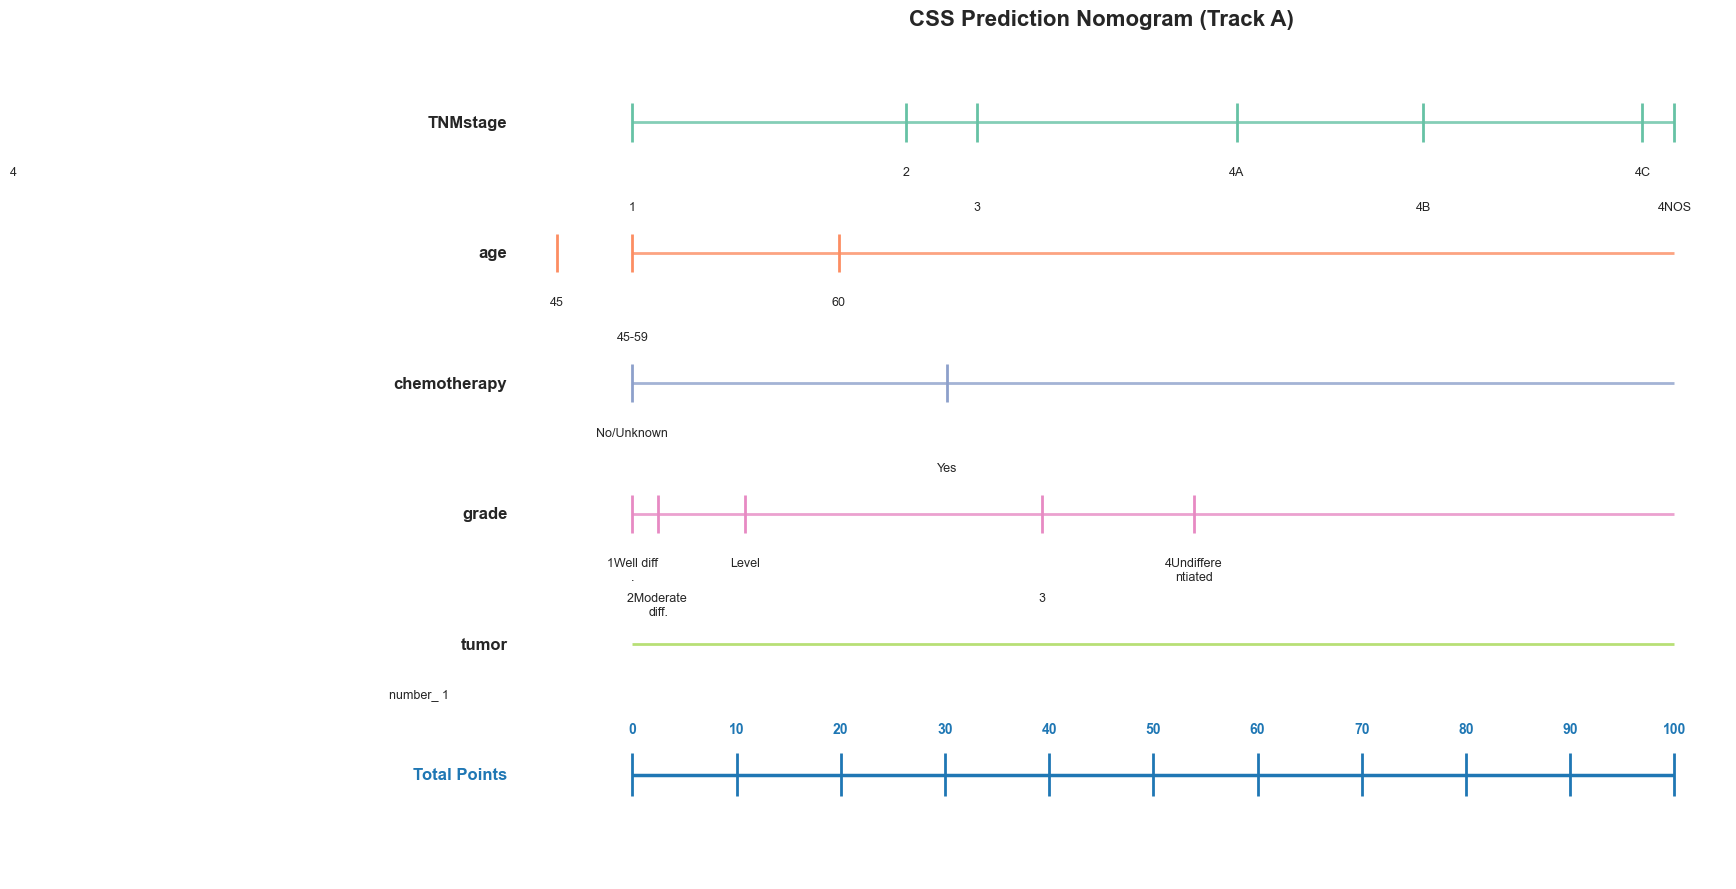


CSS nomogram saved: nomogram_css_trackA.png


In [32]:
# Plot CSS nomogram
fig_css = plot_nomogram_horizontal(css_points, "CSS Prediction Nomogram (Track A)")
plt.show()

# Save figure
fig_css.savefig(output_dir / "nomogram_css_trackA.png", dpi=300, bbox_inches="tight")
print("\nCSS nomogram saved: nomogram_css_trackA.png")

## 8. Create Risk Prediction Calculator

Build a function to calculate survival probabilities for individual patients based on their characteristics.

In [33]:
def calculate_linear_predictor(patient_vars, point_table, model_results):
    """
    Calculate the linear predictor (prognostic index) for a patient.

    Args:
        patient_vars: Dict with patient characteristics {var_name: level}
        point_table: DataFrame with point assignments
        model_results: Dict with model coefficients

    Returns:
        linear_predictor: Sum of coefficients for patient's characteristics
        total_points: Total nomogram points
        breakdown: Dict with points by variable
    """
    coefficients = model_results["coefficients"]

    linear_predictor = 0.0
    total_points = 0.0
    breakdown = {}

    for var_name, level in patient_vars.items():
        # Find the dummy variable name
        dummy_var = f"{var_name}_{level}"

        if dummy_var in coefficients:
            coef = coefficients[dummy_var]
            linear_predictor += coef

            # Get points
            points_row = point_table[
                (point_table["Variable"] == var_name) & (point_table["Level"] == level)
            ]

            if not points_row.empty:
                points = points_row["Points"].values[0]
                total_points += points
                breakdown[var_name] = {
                    "level": level,
                    "points": points,
                    "coefficient": coef,
                }
        else:
            # Reference category (0 coefficient, 0 points)
            breakdown[var_name] = {"level": level, "points": 0.0, "coefficient": 0.0}

    return linear_predictor, total_points, breakdown


def predict_survival_probability(linear_predictor, baseline_survival, time_point):
    """
    Calculate survival probability at a specific time point.

    S(t|X) = S0(t)^exp(Xβ)

    Args:
        linear_predictor: Patient's prognostic index (Xβ)
        baseline_survival: Baseline survival at time t (S0(t))
        time_point: Time in months

    Returns:
        survival_prob: Predicted survival probability
    """
    # Cox model formula
    survival_prob = baseline_survival ** np.exp(linear_predictor)

    return survival_prob


print("Risk calculation functions defined")

Risk calculation functions defined


## 9. Example Risk Predictions

Demonstrate nomogram usage with example patients.

In [34]:
# Example patients for demonstration
# NOTE: These are hypothetical examples - adjust based on actual selected variables

print("=" * 70)
print("EXAMPLE RISK PREDICTIONS")
print("=" * 70)

# Get the actual selected variables from the OS model
selected_vars = os_model_results["selected_variables"]
print(f"\nSelected variables in OS model: {selected_vars}")
print("\nTo use the nomogram:")
print("1. Define patient characteristics matching the selected variables")
print("2. Look up points for each characteristic")
print("3. Sum total points")
print("4. Use total points to estimate survival probability")

# Example calculation (will need to be customized based on actual variables)
print("\n--- Example Patient ---")
print("Define patient characteristics as a dictionary:")
print("patient_example = {")
for var in selected_vars[:3]:  # Show first 3 variables as example
    print(f"    '{var}': 'level_value',  # Replace with actual level")
print("    ...")
print("}")

print("\nThen calculate:")
print("linear_pred, total_pts, breakdown = calculate_linear_predictor(")
print("    patient_example, os_points, os_model_results)")

EXAMPLE RISK PREDICTIONS

Selected variables in OS model: ['TNMstage', 'age', 'chemotherapy', 'radiotherapy', 'marital_status', 'grade']

To use the nomogram:
1. Define patient characteristics matching the selected variables
2. Look up points for each characteristic
3. Sum total points
4. Use total points to estimate survival probability

--- Example Patient ---
Define patient characteristics as a dictionary:
patient_example = {
    'TNMstage': 'level_value',  # Replace with actual level
    'age': 'level_value',  # Replace with actual level
    'chemotherapy': 'level_value',  # Replace with actual level
    ...
}

Then calculate:
linear_pred, total_pts, breakdown = calculate_linear_predictor(
    patient_example, os_points, os_model_results)


## 10. Estimate Baseline Survival Function

To make actual survival predictions, we need the baseline survival function S₀(t) at key time points (e.g., 1-year, 3-year, 5-year).

In [35]:
# Rebuild Cox models to extract baseline survival
from lifelines import CoxPHFitter


def rebuild_cox_model(train_data, selected_vars, time_col, event_col):
    """
    Rebuild Cox model to extract baseline survival function.
    """
    # Prepare data with dummy variables
    cox_data = train_data[[time_col, event_col]].copy()

    for var in selected_vars:
        if var == "TNMstage":
            var_data = train_data[var].astype(str)
            dummies = pd.get_dummies(var_data, prefix=var, drop_first=True, dtype=float)
        else:
            dummies = pd.get_dummies(
                train_data[var], prefix=var, drop_first=True, dtype=float
            )

        for col in dummies.columns:
            cox_data[col] = dummies[col]

    cox_data = cox_data.dropna()

    # Fit model
    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(cox_data, duration_col=time_col, event_col=event_col)

    return cph, cox_data


print("Rebuilding OS model...")
os_cph, os_cox_data = rebuild_cox_model(
    train, os_model_results["selected_variables"], "time_os", "event_os"
)

print("Rebuilding CSS model...")
css_cph, css_cox_data = rebuild_cox_model(
    train, css_model_results["selected_variables"], "time_css", "event_css"
)

print("\nModels rebuilt successfully!")

Rebuilding OS model...
Rebuilding CSS model...

Models rebuilt successfully!


In [41]:
# Extract baseline survival at key time points
time_points = [12, 36, 60]  # 1-year, 3-year, 5-year in months

print("=" * 70)
print("BASELINE SURVIVAL ESTIMATES")
print("=" * 70)

# OS baseline survival
print("\n--- OS Baseline Survival S₀(t) ---")
os_baseline = os_cph.baseline_survival_
for t in time_points:
    # Find closest time point
    idx = np.abs(os_baseline.index - t).argmin()
    s0_t = os_baseline.iloc[idx, 0]  # Get scalar value from first column
    print(f"  {t} months ({t//12} years): S₀(t) = {s0_t:.4f}")

# CSS baseline survival
print("\n--- CSS Baseline Survival S₀(t) ---")
css_baseline = css_cph.baseline_survival_
for t in time_points:
    idx = np.abs(css_baseline.index - t).argmin()
    s0_t = css_baseline.iloc[idx, 0]  # Get scalar value from first column
    print(f"  {t} months ({t//12} years): S₀(t) = {s0_t:.4f}")

BASELINE SURVIVAL ESTIMATES

--- OS Baseline Survival S₀(t) ---
  12 months (1 years): S₀(t) = 0.9416
  36 months (3 years): S₀(t) = 0.8447
  60 months (5 years): S₀(t) = 0.7688

--- CSS Baseline Survival S₀(t) ---
  12 months (1 years): S₀(t) = 0.9608
  36 months (3 years): S₀(t) = 0.8928
  60 months (5 years): S₀(t) = 0.8423


## 11. Complete Nomogram with Survival Probability Scale

In [42]:
def plot_complete_nomogram(
    point_table, baseline_survival, time_points, title, figsize=(18, 12)
):
    """
    Create complete nomogram with survival probability scales.

    Args:
        point_table: DataFrame with variable points
        baseline_survival: Baseline survival function from CoxPHFitter
        time_points: List of time points (in months) for survival prediction
        title: Plot title
        figsize: Figure size
    """
    fig, ax = plt.subplots(figsize=figsize)

    variables = point_table["Variable_Display"].unique()
    n_vars = len(variables)

    spacing = 1.5
    y_positions = np.arange(n_vars + len(time_points) + 1, 0, -1) * spacing

    colors = sns.color_palette("Set2", n_colors=n_vars)

    for i, var_display in enumerate(variables):
        var_data = point_table[point_table["Variable_Display"] == var_display].copy()
        var_data = var_data.sort_values("Points")

        y = y_positions[i]
        color = colors[i]

        ax.text(
            -12, y, var_display, ha="right", va="center", fontweight="bold", fontsize=12
        )
        ax.hlines(y, 0, 100, color=color, linewidth=2, alpha=0.8)

        for j, row in enumerate(var_data.itertuples(index=False)):
            points = row.Points
            level = format_level_label(row.Level, max_len=10)

            ax.vlines(points, y - 0.22, y + 0.22, color=color, linewidth=2)
            label_y = y - 0.5 if j % 2 == 0 else y - 0.9
            ax.text(
                points,
                label_y,
                level,
                ha="center",
                va="top",
                fontsize=9,
                rotation=0,
            )

    y_total = y_positions[n_vars]
    ax.text(
        -12,
        y_total,
        "Total Points",
        ha="right",
        va="center",
        fontweight="bold",
        fontsize=12,
        color="#1f77b4",
    )
    ax.hlines(y_total, 0, 100, color="#1f77b4", linewidth=2.5)

    for p in range(0, 101, 10):
        ax.vlines(p, y_total - 0.25, y_total + 0.25, color="#1f77b4", linewidth=2)
        ax.text(
            p,
            y_total + 0.45,
            str(p),
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
            color="#1f77b4",
        )

    max_coef = max(abs(c) for c in point_table["Coefficient"] if c != 0)

    for t_idx, t in enumerate(time_points):
        y_surv = y_positions[n_vars + 1 + t_idx]

        idx = np.abs(baseline_survival.index - t).argmin()
        s0_t = baseline_survival.iloc[idx, 0]  # Get scalar value from first column

        ax.text(
            -12,
            y_surv,
            f"{t//12}-Year Survival",
            ha="right",
            va="center",
            fontweight="bold",
            fontsize=12,
            color="#d62728",
        )
        ax.hlines(y_surv, 0, 100, color="#d62728", linewidth=2, alpha=0.8)

        for points in range(0, 101, 20):
            linear_pred = (points / 100) * max_coef
            surv_prob = s0_t ** np.exp(linear_pred)

            ax.vlines(
                points, y_surv - 0.22, y_surv + 0.22, color="#d62728", linewidth=2
            )
            ax.text(
                points,
                y_surv - 0.5,
                f"{surv_prob:.2f}",
                ha="center",
                va="top",
                fontsize=9,
                fontweight="bold",
                color="#d62728",
            )

    ax.set_xlim(-15, 105)
    ax.set_ylim(-1.2, max(y_positions) + 0.8)
    ax.set_title(title, fontsize=16, fontweight="bold", pad=20)
    ax.axis("off")

    plt.tight_layout()
    return fig


print("Complete nomogram plotting function defined")

Complete nomogram plotting function defined


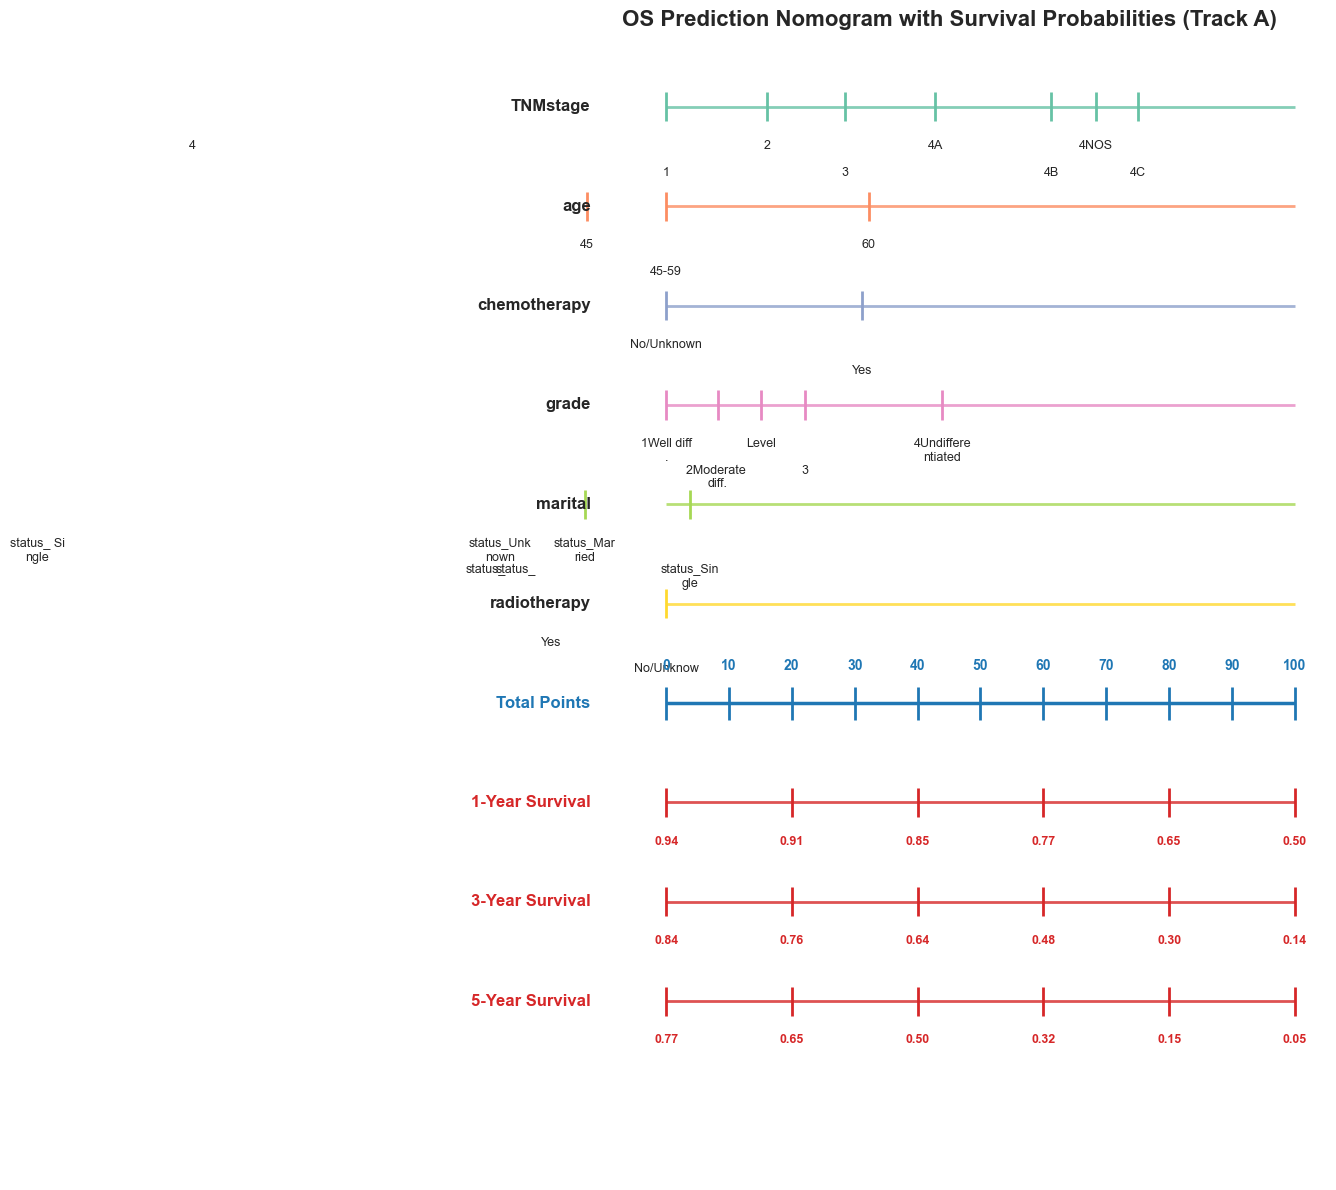

Complete OS nomogram saved: nomogram_os_complete_trackA.png


In [43]:
# Plot complete OS nomogram with survival scales
fig_os_complete = plot_complete_nomogram(
    os_points,
    os_baseline,
    time_points=[12, 36, 60],
    title="OS Prediction Nomogram with Survival Probabilities (Track A)",
)
plt.show()

fig_os_complete.savefig(
    output_dir / "nomogram_os_complete_trackA.png", dpi=300, bbox_inches="tight"
)
print("Complete OS nomogram saved: nomogram_os_complete_trackA.png")

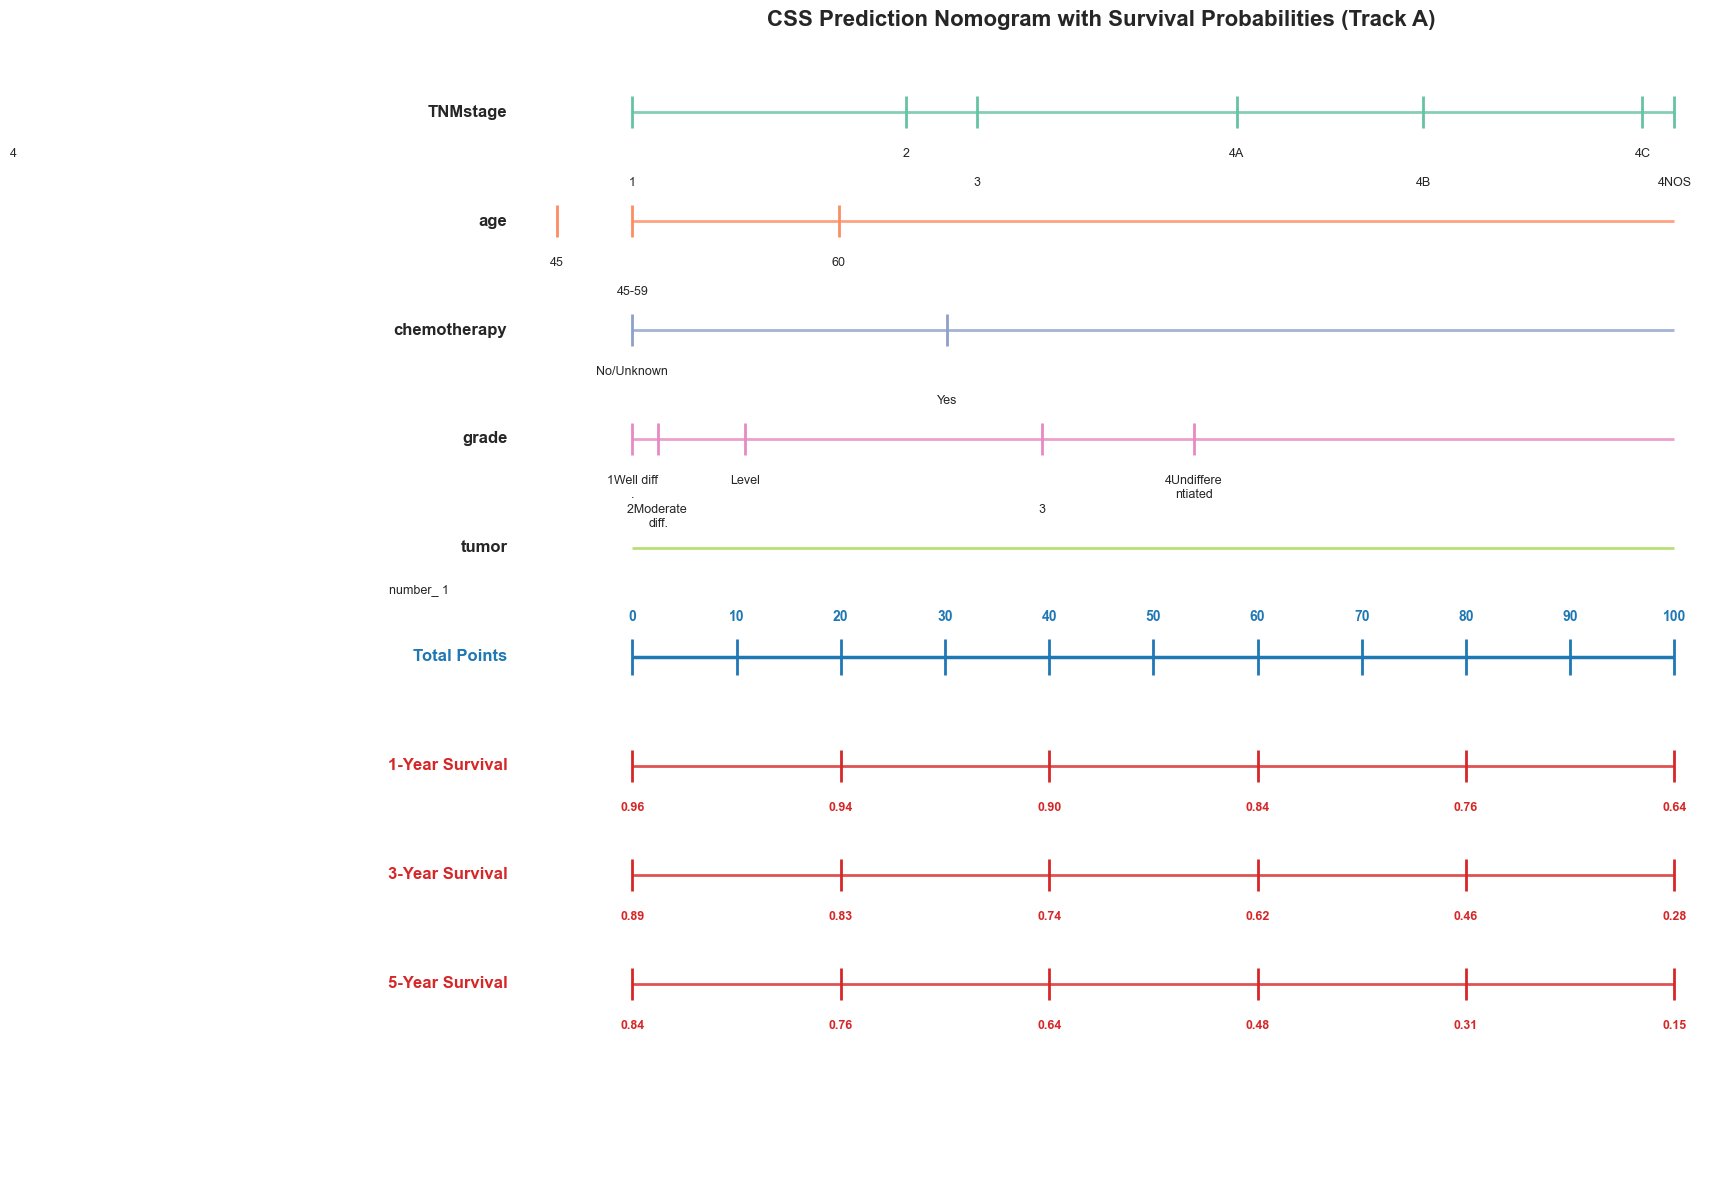

Complete CSS nomogram saved: nomogram_css_complete_trackA.png


In [44]:
# Plot complete CSS nomogram with survival scales
fig_css_complete = plot_complete_nomogram(
    css_points,
    css_baseline,
    time_points=[12, 36, 60],
    title="CSS Prediction Nomogram with Survival Probabilities (Track A)",
)
plt.show()

fig_css_complete.savefig(
    output_dir / "nomogram_css_complete_trackA.png", dpi=300, bbox_inches="tight"
)
print("Complete CSS nomogram saved: nomogram_css_complete_trackA.png")

## 12. Save Nomogram Point Tables

In [45]:
# Save point tables
os_points.to_csv(output_dir / "nomogram_os_points_trackA.csv", index=False)
css_points.to_csv(output_dir / "nomogram_css_points_trackA.csv", index=False)

print("Point tables saved:")
print("  - nomogram_os_points_trackA.csv")
print("  - nomogram_css_points_trackA.csv")

# Save baseline survival estimates
baseline_info = {
    "os_baseline": {
        str(t): float(os_baseline.iloc[np.abs(os_baseline.index - t).argmin(), 0])
        for t in [12, 36, 60]
    },
    "css_baseline": {
        str(t): float(css_baseline.iloc[np.abs(css_baseline.index - t).argmin(), 0])
        for t in [12, 36, 60]
    },
}

with open(output_dir / "nomogram_baseline_survival_trackA.json", "w") as f:
    json.dump(baseline_info, f, indent=2)

print("\nBaseline survival estimates saved:")
print("  - nomogram_baseline_survival_trackA.json")

Point tables saved:
  - nomogram_os_points_trackA.csv
  - nomogram_css_points_trackA.csv

Baseline survival estimates saved:
  - nomogram_baseline_survival_trackA.json


## Summary

### Nomogram Construction Complete

**Created:**
- Point assignment systems for OS and CSS models
- Visual nomogram representations
- Complete nomograms with survival probability scales
- Risk calculation functions

**Key Features:**
- Each variable level assigned points proportional to hazard ratio
- Total points range from 0 to 100
- Survival probabilities displayed for 1-year, 3-year, and 5-year endpoints
- Point tables saved for reference

**Clinical Use:**
1. For each patient, identify their characteristics
2. Look up points for each characteristic on the nomogram
3. Sum total points
4. Read predicted survival probability from the appropriate time scale

**Outputs:**
- `nomogram_os_trackA.png` - OS nomogram (simplified)
- `nomogram_css_trackA.png` - CSS nomogram (simplified)
- `nomogram_os_complete_trackA.png` - OS nomogram with survival scales
- `nomogram_css_complete_trackA.png` - CSS nomogram with survival scales
- `nomogram_os_points_trackA.csv` - OS point assignment table
- `nomogram_css_points_trackA.csv` - CSS point assignment table
- `nomogram_baseline_survival_trackA.json` - Baseline survival estimates

### Next Steps
- **Notebook 05**: Calibration curves and model assessment
- **Notebook 06**: External validation on Track B cohort

In [46]:
# Explore T, N, M component availability in SEER data
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path("data/processed")

trackA_train = pd.read_pickle(DATA_DIR / "trackA_train.pkl")
trackA_val = pd.read_pickle(DATA_DIR / "trackA_val.pkl")

print("=" * 60)
print("T, N, M COMPONENT ANALYSIS IN SEER DATA")
print("=" * 60)

# Check what columns are available
tnm_cols = [
    c
    for c in trackA_train.columns
    if c.lower() in ["t", "n", "m", "t_stage", "n_stage", "m_stage", "tnmstage"]
]
print(f"\nTNM-related columns in SEER: {trackA_train.columns.tolist()}")

# Check if T, N, M are separate
for col in ["T", "N", "M", "t", "n", "m"]:
    if col in trackA_train.columns:
        print(f"\n{col} distribution:")
        print(trackA_train[col].value_counts())

FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/trackA_train.pkl'

In [47]:
import os

os.chdir("/Users/stan/Documents/UOM/myn_project")

import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path("data/processed")

trackA_train = pd.read_pickle(DATA_DIR / "trackA_train.pkl")
trackA_val = pd.read_pickle(DATA_DIR / "trackA_val.pkl")

print("=" * 60)
print("T, N, M COMPONENT ANALYSIS IN SEER DATA")
print("=" * 60)

# Check all columns available
print("\nAll columns in SEER training data:")
print(trackA_train.columns.tolist())

T, N, M COMPONENT ANALYSIS IN SEER DATA

All columns in SEER training data:
['ID', 'age', 'sex', 'grade', 'radiotherapy', 'chemotherapy', 'tumor_number', 'race', 'marital_status', 'urban_rural', 'time_os', 'event_os', 'TNMstage', 'site', 'event_css', 'time_css']


In [48]:
# Check if separate T, N, M are in the raw SEER data
raw_seer_path = Path("ACC数据/r分析seer/SEER纯ACC数据.xlsx")

if raw_seer_path.exists():
    raw_seer = pd.read_excel(raw_seer_path)
    print("Raw SEER columns:")
    print(raw_seer.columns.tolist())

    # Look for T, N, M columns
    tnm_cols = [
        c
        for c in raw_seer.columns
        if any(
            x in c.lower()
            for x in ["_t", "_n", "_m", "tstage", "nstage", "mstage", "ajcc"]
        )
    ]
    print(f"\nPotential TNM columns: {tnm_cols}")
else:
    print(f"File not found: {raw_seer_path}")

Raw SEER columns:
['编号', '年龄', '性别', '部位ICD-O-3/WHO 2008', 'TNM 7/CS v0204+ Schema (thru 2017)', 'TNM 7/CS v0204+ Schema recode', '部位ICD-O-3 2023 Revision', '部位ICD-O-3 2023 Revision Expanded', '原发部位', '原发部位序号', '组织学类型ICD-O-3', '分化级别(thru 2017)', '综合分级2018 (2018+)', '临床分级(2018+)', '病理学分级(2018+)', '左右', 'EOD分级(2018+)', 'Derived EOD 2018 T (2018+)', 'Derived EOD 2018 N (2018+)', 'Derived EOD 2018 M (2018+)', 'TNM 7th ed (2010-2015)', 'T, 7th ed (2010-2015)', 'N, 7th ed (2010-2015)', 'M, 7th ed (2010-2015)', '7th Edition Stage Group Recode (2016-2017)', 'TNM 6th ed (2004-2015)', 'T, 6th ed (2004-2015)', 'N,6th ed (2004-2015)', 'M, 6th ed (2004-2015)', 'RX Summ--Surg Prim Site (1998+)', 'RX Summ--Scope Reg LN Sur (2003+)', 'RX Summ--Surg Oth Reg/Dis (2003+)', 'RX Summ--Surg/Rad Seq', '放疗', '化疗', '肿瘤数量', '种族', '婚姻', '城乡', '死因（肿瘤部位重编码', 'SEER cause-specific death classification', 'SEER other cause of death classification', '存活月数', '存活月数标记', 'COD to site rec KM', 'COD to site recode ICD-O-3 20

In [ ]:
# Great! Raw SEER has separate T, N, M columns. Let's explore them.
raw_seer = pd.read_excel(raw_seer_path)

print("=" * 60)
print("SEPARATE T, N, M COMPONENTS IN RAW SEER DATA")
print("=" * 60)

# Check the separate T, N, M columns at the end
print("\n--- T distribution ---")
print(raw_seer['T'].value_counts())

print("\n--- N distribution ---")
print(raw_seer['N'].value_counts())

print("\n--- M distribution ---")
print(raw_seer['M'].value_counts())


In [ ]:
import os
os.chdir("/Users/stan/Documents/UOM/myn_project")

import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path("data/processed")
trackA_train = pd.read_pickle(DATA_DIR / "trackA_train.pkl")

print("=" * 60)
print("T, N, M COMPONENTS IN SEER TRACK A")
print("=" * 60)

# Check if T, N, M columns exist
print("\nColumns available:", trackA_train.columns.tolist())
